In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import save_image
import os
import math
import numpy as np
from tqdm import tqdm


#DDPM

In [2]:
class DDPMSampler:
    def __init__(self, generator: torch.Generator, num_steps=1000, beta_start=0.001, beta_end=0.015):
        self.generator = generator
        self.num_steps = num_steps
        self.betas = torch.linspace(beta_start, beta_end, num_steps)
        self.alphas = 1.0 - self.betas
        self.alphas_cumprod = torch.cumprod(self.alphas, dim=0)
        self.one = torch.tensor(1.0)

        self.timesteps = torch.from_numpy(np.arange(0, num_steps)[::-1].copy())

    def set_inference_timesteps(self, num_inference_steps=50):
        self.num_inference_steps = num_inference_steps
        step_ratio = self.num_steps // self.num_inference_steps
        timesteps = (np.arange(0, num_inference_steps) * step_ratio).round()[::-1].copy().astype(np.int64)
        self.timesteps = torch.from_numpy(timesteps)

    def get_previous_timesteps(self, timestep: int) -> int:
        prev_t = timestep - self.num_steps // self.num_inference_steps
        return prev_t

    def get_variance(self, timestep: int):
        prev_t = self.get_previous_timesteps(timestep)

        alpha_prod_t = self.alphas_cumprod[timestep]
        # if prev_t >=0 take alpha_prod_t_prev, else take 1
        alpha_prod_t_prev = self.alphas_cumprod[prev_t] if prev_t >= 0 else self.one
        current_beta = 1 - alpha_prod_t / alpha_prod_t_prev

        variance = (1 - alpha_prod_t_prev) / (1 - alpha_prod_t) * current_beta
        variance = torch.clamp(variance, min = 1e-20)
        return variance

    def set_strength(self, strength=1):
        #set how much noise add to image much: strength ~ 1, less: strength ~ 0
        start_step = self.num_inference_steps - int(self.num_inference_steps * strength)
        self.timesteps = self.timesteps[start_step:]
        self.start_step = start_step

    def step(self, timestep: int, latents: torch.Tensor, model_output: torch.Tensor):
        t = timestep
        prev_t = self.get_previous_timesteps(t)

        #Compute alphas, betas
        alpha_prod_t = self.alphas_cumprod[t]
        alpha_prod_t_prev = self.alphas_cumprod[prev_t] if prev_t >= 0 else self.one
        beta_prod_t = 1 - alpha_prod_t
        beta_prod_t_prev = 1 - alpha_prod_t_prev
        current_alpha = alpha_prod_t / alpha_prod_t_prev
        current_beta = 1 - current_alpha

        #Compute predicted original sample (predict x_0)
        pred_original_sample = (latents - beta_prod_t ** (0.5) * model_output) / alpha_prod_t ** (0.5)

        #Compute coefficients for x_0 and X_t
        pred_original_sample_coeff = (alpha_prod_t_prev ** 0.5 * current_beta) / beta_prod_t
        current_sample = current_alpha ** 0.5 * beta_prod_t_prev / beta_prod_t

        #Compute u_t
        pred_prev_sample = pred_original_sample_coeff * pred_original_sample + current_sample * latents

        #Add noise
        variance = 0
        if t > 0:
            device = model_output.device
            noise = torch.randn(model_output.shape, generator=self.generator, device=device, dtype=model_output.dtype)

            variance = (self.get_variance(t) ** (0.5) * noise)

        pred_prev_sample = pred_prev_sample + variance

        return pred_prev_sample

    def add_noise(self, original_samples: torch.Tensor, timesteps: torch.IntTensor) -> torch.FloatTensor:
        #Add noise to
        alphas_cumprod = self.alphas_cumprod.to(device=original_samples.device, dtype=original_samples.dtype)
        timesteps = timesteps.to(original_samples.device)

        sqrt_alpha_prod = alphas_cumprod[timesteps] ** 0.5
        sqrt_alpha_prod = sqrt_alpha_prod.flatten()

        while len(sqrt_alpha_prod.shape) < len(original_samples.shape):
            sqrt_alpha_prod = sqrt_alpha_prod.unsqueeze(-1)

        sqrt_one_minus_alpha_prod = (1 - alphas_cumprod[timesteps]) ** 0.5
        sqrt_one_minus_alpha_prod = sqrt_one_minus_alpha_prod.flatten()

        while len(sqrt_one_minus_alpha_prod.shape) < len(original_samples.shape):
            sqrt_one_minus_alpha_prod = sqrt_one_minus_alpha_prod.unsqueeze(-1)

        noise = torch.randn(original_samples.shape, generator=self.generator, device=original_samples.device, dtype=original_samples.dtype)
        noisy_samples = sqrt_alpha_prod * original_samples + sqrt_one_minus_alpha_prod * noise
        return noisy_samples


#Attention

In [3]:
class SelfAttention(nn.Module):
    def __init__(self, n_heads, d_embed, in_proj_bias=True, out_proj_bias=True):
        super().__init__()
        # Kết hợp Wq, Wk, Wv thành một ma trận
        self.in_proj = nn.Linear(d_embed, 3 * d_embed, bias=in_proj_bias)
        # Ma trận Wo
        self.out_proj = nn.Linear(d_embed, d_embed, bias=out_proj_bias)
        self.n_heads = n_heads
        self.d_head = d_embed // n_heads

    def forward(self, x, causal_mask=False):
        # x: (Batch_Size, Seq_Len, Dim)
        input_shape = x.shape
        batch_size, sequence_length, d_embed = input_shape
        interim_shape = (batch_size, sequence_length, self.n_heads, self.d_head)

        # Tách thành Q, K, V
        q, k, v = self.in_proj(x).chunk(3, dim=-1)

        # Chuyển đổi kích thước để thực hiện attention đa đầu
        q = q.view(interim_shape).transpose(1, 2)
        k = k.view(interim_shape).transpose(1, 2)
        v = v.view(interim_shape).transpose(1, 2)

        # Tính ma trận attention score
        weight = q @ k.transpose(-1, -2)

        if causal_mask:
            # Che đi phần tương lai (phục vụ mô hình sinh)
            mask = torch.ones_like(weight, dtype=torch.bool).triu(1)
            weight.masked_fill_(mask, -torch.inf)

        # Chuẩn hóa
        weight /= math.sqrt(self.d_head)
        weight = F.softmax(weight, dim=-1)

        # Tính output của attention
        output = weight @ v
        output = output.transpose(1, 2)
        output = output.reshape(input_shape)

        # Áp dụng linear cuối
        output = self.out_proj(output)
        return output


In [4]:
class CrossAttention(nn.Module):
    def __init__(self, n_heads, d_embed, d_cross, in_proj_bias=True, out_proj_bias=True):
        super().__init__()
        self.q_proj   = nn.Linear(d_embed, d_embed, bias=in_proj_bias)   # ánh xạ truy vấn từ x
        self.k_proj   = nn.Linear(d_cross, d_embed, bias=in_proj_bias)   # ánh xạ khóa từ y
        self.v_proj   = nn.Linear(d_cross, d_embed, bias=in_proj_bias)   # ánh xạ giá trị từ y
        self.out_proj = nn.Linear(d_embed, d_embed, bias=out_proj_bias)
        self.n_heads = n_heads
        self.d_head = d_embed // n_heads

    def forward(self, x, y):
        # x: latent (Batch_Size, Seq_Len_Q, Dim_Q)
        # y: context (Batch_Size, Seq_Len_KV, Dim_KV)

        input_shape = x.shape
        batch_size, sequence_length, d_embed = input_shape
        interim_shape = (batch_size, -1, self.n_heads, self.d_head)

        q = self.q_proj(x)
        k = self.k_proj(y)
        v = self.v_proj(y)

        q = q.view(interim_shape).transpose(1, 2)
        k = k.view(interim_shape).transpose(1, 2)
        v = v.view(interim_shape).transpose(1, 2)

        # Tính attention score: Q @ K^T
        weight = q @ k.transpose(-1, -2)
        weight /= math.sqrt(self.d_head)
        weight = F.softmax(weight, dim=-1)

        # Tính output: attention * V
        output = weight @ v
        output = output.transpose(1, 2).contiguous()
        output = output.view(input_shape)
        output = self.out_proj(output)

        return output


#CLIP

In [5]:
class CLIPEmbedding(nn.Module):
    def __init__(self, n_vocab, n_embed, n_tokens):
        super().__init__()
        self.token_embedding = nn.Embedding(n_vocab, n_embed)
        self.position_embedding = nn.Parameter(torch.zeros(n_tokens, n_embed))

    def forward(self, x):
        x = self.token_embedding(x)
        x += self.position_embedding

        return x


class CLIPlayer(nn.Module):
    def __init__(self, n_heads, d_embed):
        super().__init__()

        self.layer_norm1 = nn.LayerNorm(d_embed)
        self.attention = SelfAttention(n_heads, d_embed)
        self.layer_norm2 = nn.LayerNorm(d_embed)

        self.linear1 = nn.Linear(d_embed, 4 * d_embed)
        self.linear2 = nn.Linear(4 * d_embed, d_embed)


    def forward(self, x):
        residue = x
        x = self.layer_norm1(x)
        x = self.attention(x, causal_mask = True)
        x+= residue

        residue = x
        x = self.layer_norm2(x)
        x = self.linear1(x)
        x = x * torch.sigmoid(1.702 * x)
        x = self.linear2(x)

        x += residue

        return x


In [6]:
class CLIP(nn.Module):
    def __init__(self):
        super().__init__()
        self.embedding = CLIPEmbedding(n_vocab=50257, n_embed=768, n_tokens=77)
        self.layers = nn.ModuleList([
            CLIPlayer(n_heads=12, d_embed=768) for _ in range(12)
        ])

        self.layer_norm = nn.LayerNorm(768)

    def forward(self, tokens: torch.LongTensor) -> torch.LongTensor:
        tokens = tokens.type(torch.long)

        state = self.embedding(tokens)

        for layer in self.layers:
            state = layer(state)

        output = self.layernorm(state)

        return output


#VAE

In [7]:
class VAE_ResidualBlock(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()
        self.groupnorm_1 = nn.GroupNorm(num_groups=32, num_channels=in_c)

        self.conv_1 = nn.Conv2d(in_c, out_c, kernel_size=3, padding=1)
        self.groupnorm_2 = nn.GroupNorm(num_groups=32, num_channels=out_c)

        self.conv_2 = nn.Conv2d(out_c, out_c, kernel_size=3, padding=1)

        if in_c == out_c:
            self.residual_layer = nn.Identity()
        else:
            self.residual_layer = nn.Conv2d(in_c, out_c, kernel_size=1)

    def forward(self, x):
        residue = x

        x = self.groupnorm_1(x)
        x = F.silu(x)
        x = self.conv_1(x)
        x = self.groupnorm_2(x)
        x = F.silu(x)
        x = self.conv_2(x)

        return x + self.residual_layer(residue)

class VAE_AttentionBlock(nn.Module):
    def __init__(self, in_c):
        super().__init__()
        self.groupnorm = nn.GroupNorm(num_groups=32, num_channels=in_c)
        self.attention = SelfAttention(n_heads=1, d_embed=in_c)

    def forward(self, x):
        residue = x
        x = self.groupnorm(x)

        n , c, h, w = x.shape
        x = x.view(n,c,h*w)
        x = x.transpose(-1,-2) # (bs,h*w,c)
        x= self.attention(x)
        x = x.transpose(-1,-2)
        x = x.view(n,c,h,w)
        x += residue

        return x

##Encoder

In [8]:
class VAE_Encoder(nn.Sequential):
    def __init__(self):
        super().__init__(
            # (bs, 3, h, w) -> (bs, 128, h, w)
            nn.Conv2d(3, 128, kernel_size=3, padding=1),
            VAE_ResidualBlock(128, 128),
            VAE_ResidualBlock(128, 128),

            # (bs, 128, h, w) -> (bs, 128, h/2, w/2)
            nn.Conv2d(128, 128, kernel_size=3, stride=2, padding=0),
            VAE_ResidualBlock(128, 256),
            VAE_ResidualBlock(256, 256),

            # (bs, 256, h/2, w/2) -> (bs, 256, h/4, w/4)
            nn.Conv2d(256, 256, kernel_size=3, stride=2, padding=0),
            VAE_ResidualBlock(256, 512),
            VAE_ResidualBlock(512, 512),

            # (bs, 512, h/4, w/4) -> (bs, 512, h/8, w/8)
            nn.Conv2d(512, 512, kernel_size=3, stride=2, padding=0),
            VAE_ResidualBlock(512, 512),
            VAE_ResidualBlock(512, 512),
            VAE_ResidualBlock(512, 512),

            VAE_AttentionBlock(512),
            VAE_ResidualBlock(512, 512),

            nn.GroupNorm(32, 512),
            nn.SiLU(),

            nn.Conv2d(512, 8, kernel_size=3, padding=1),
            nn.Conv2d(8, 8, kernel_size=3, padding=0),  # (bs, 8, h/8, w/8)
        )

    def forward(self, x: torch.Tensor, noise: torch.Tensor) -> torch.Tensor:
        # x: ảnh đầu vào (bs, c, h, w)
        # noise: nhiễu chuẩn hóa (bs, 8, h/8, w/8)

        for module in self:
            if getattr(module, 'stride', None) == (2, 2):
                x = F.pad(x, (0, 1, 0, 1))  # pad ảnh trước khi downsample
            x = module(x)

        # Tách tensor thành 2 phần: trung bình và log phương sai
        mean, log_variance = torch.chunk(x, 2, dim=1)

        log_variance = torch.clamp(log_variance, -30, 20)
        variance = log_variance.exp()
        stdev = variance.sqrt()

        x = mean + stdev * noise

        # Scale đầu ra
        x *= 0.18215

        return x


##Decoder

In [9]:
class VAE_Decoder(nn.Sequential):
    def __init__(self):
        super().__init__(
            nn.Conv2d(4,4,kernel_size= 1, padding= 0),

            nn.Conv2d(4,512,kernel_size= 1, padding= 1),

            VAE_ResidualBlock(512,512),
            VAE_AttentionBlock(512),
            VAE_ResidualBlock(512,512),
            VAE_ResidualBlock(512,512),
            VAE_ResidualBlock(512,512),
            VAE_ResidualBlock(512,512), #(bs,512,h/8,w/8)

            nn.Upsample(scale_factor=2), #(bs,512,h/4,w/4)

            nn.Conv2d(512,512,kernel_size= 3, padding = 1),
            VAE_ResidualBlock(512,512),
            VAE_ResidualBlock(512,512),
            VAE_ResidualBlock(512,512),

            nn.Upsample(scale_factor=2), #(bs,512,h/2,w/2)



            nn.Conv2d(512,512,kernel_size= 3, padding = 1),
            VAE_ResidualBlock(512,256),
            VAE_ResidualBlock(256,256),
            VAE_ResidualBlock(256,256),

            nn.Upsample(scale_factor=2), #(bs,512,h,w)

            nn.Conv2d(256,256,kernel_size= 3, padding = 1),
            VAE_ResidualBlock(256,128),
            VAE_ResidualBlock(128,128),
            VAE_ResidualBlock(128,128),

            nn.GroupNorm(32,128),
            nn.SiLU(),
            nn.Conv2d(128,3,kernel_size= 3, padding= 1)

        )

    def forward(self , x : torch.Tensor) -> torch.Tensor:
        # x: (bs, 4,h/8,w/8)

        x /= 0.18215

        for module in self:
            x = module(x)

        return x

#UNET

In [10]:
class TimeEmbedding(nn.Module):
    def __init__(self, n_embd):
        super().__init__()
        self.linear_1 = nn.Linear(n_embd, 4 * n_embd)
        self.linear_2 = nn.Linear(4 * n_embd, 4 * n_embd)

    def forward(self, x):
        # x: (1, 320)

        # (1, 320) -> (1, 1280)
        x = self.linear_1(x)

        # (1, 1280) -> (1, 1280)
        x = F.silu(x)

        # (1, 1280) -> (1, 1280)
        x = self.linear_2(x)

        return x

In [11]:
class SwitchSequential(nn.Sequential):
    def forward(self, x, context, time):
        for layer in self:
            if isinstance(layer, UNET_AttentionBlock):
                x = layer(x, context)
            elif isinstance(layer, UNET_ResidualBlock):
                x = layer(x, time)
            else:
                x = layer(x)

        return x


In [12]:
class Upsample(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.conv = nn.Conv2d(channels, channels, kernel_size=3, padding=1)

    def forward(self, x):
        # (Batch_Size, Features, Height, Width) -> (Batch_Size, Features, Height * 2, Width * 2)
        x = F.interpolate(x, scale_factor=2, mode='nearest')
        return self.conv(x)

In [13]:
class UNET_ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, n_time=1280):
        super().__init__()
        self.groupnorm_feature = nn.GroupNorm(32, in_channels)
        self.conv_feature = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.linear_time = nn.Linear(n_time, out_channels)

        self.groupnorm_merged = nn.GroupNorm(32, out_channels)
        self.conv_merged = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)

        self.residual_layer = (
            nn.Identity()
            if in_channels == out_channels
            else nn.Conv2d(in_channels, out_channels, kernel_size=1, padding=0)
        )

    def forward(self, feature, time):
        # feature: (bs, in_channels, h, w)
        # time: (1, 1280)

        residue = feature

        feature = self.groupnorm_feature(feature)
        feature = F.silu(feature)
        feature = self.conv_feature(feature)

        time = F.silu(time)
        time = self.linear_time(time)

        # Cộng thông tin thời gian vào đặc trưng
        merged = feature + time.unsqueeze(-1).unsqueeze(-1)

        merged = self.groupnorm_merged(merged)
        merged = F.silu(merged)
        merged = self.conv_merged(merged)

        return merged + self.residual_layer(residue)


In [14]:
class UNET_AttentionBlock(nn.Module):
    def __init__(self, n_head: int, n_embd: int, d_context=512):
        super().__init__()
        channels = n_head * n_embd

        self.groupnorm = nn.GroupNorm(32, channels, eps=1e-6)
        self.conv_input = nn.Conv2d(channels, channels, kernel_size=1)

        self.layernorm_1 = nn.LayerNorm(channels)
        self.attention_1 = SelfAttention(n_head, channels, in_proj_bias=False)

        self.layernorm_2 = nn.LayerNorm(channels)
        self.attention_2 = CrossAttention(n_head, channels, d_context, in_proj_bias=False)

        self.layernorm_3 = nn.LayerNorm(channels)
        self.linear_geglu_1  = nn.Linear(channels, 4 * channels * 2)
        self.linear_geglu_2 = nn.Linear(4 * channels, channels)

        self.conv_output = nn.Conv2d(channels, channels, kernel_size=1)

    def forward(self, x, context):
        # x: (bs, channels, h, w)
        # context: (bs, seq_len, d_context)

        residue_long = x

        x = self.groupnorm(x)
        x = self.conv_input(x)

        n, c, h, w = x.shape

        x = x.view(n, c, h * w).transpose(-1, -2)  # -> (bs, h*w, c)

        # Self-Attention
        residue_short = x
        x = self.layernorm_1(x)
        x = self.attention_1(x)
        x += residue_short

        # Cross-Attention
        residue_short = x
        x = self.layernorm_2(x)
        x = self.attention_2(x, context)
        x += residue_short

        # GeGLU Feed Forward
        residue_short = x
        x = self.layernorm_3(x)
        x, gate = self.linear_geglu_1(x).chunk(2, dim=-1)
        x = x * F.gelu(gate)
        x = self.linear_geglu_2(x)
        x += residue_short

        x = x.transpose(-1, -2).view(n, c, h, w)

        return self.conv_output(x) + residue_long

In [15]:
class UNET(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoders = nn.ModuleList([
            # (B, 4, H, W) → (B, 320, H, W)
            SwitchSequential(nn.Conv2d(4, 320, kernel_size=3, padding=1)),
            # (B, 320, H, W)
            SwitchSequential(UNET_ResidualBlock(320, 320), UNET_AttentionBlock(8, 40)),
            # (B, 320, H, W) → (B, 640, H/2, W/2)
            SwitchSequential(nn.Conv2d(320, 640, kernel_size=3, stride=2, padding=1)),
            # (B, 640, H/2, W/2)
            SwitchSequential(UNET_ResidualBlock(640, 640), UNET_AttentionBlock(8, 80)),
        ])

        self.bottleneck = SwitchSequential(
            # (B, 640, H/2, W/2)
            UNET_ResidualBlock(640, 640),
            UNET_AttentionBlock(8, 80),
            UNET_ResidualBlock(640, 640)
        )

        self.decoders = nn.ModuleList([
            # (B, 1280, H/2, W/2) → (B, 640, H/2, W/2)
            SwitchSequential(UNET_ResidualBlock(1280, 640)),
            # (B, 1280, H/2, W/2) → (B, 320, H, W)
            SwitchSequential(UNET_ResidualBlock(1280, 320), Upsample(320)),
            # (B, 640, H, W)
            SwitchSequential(UNET_ResidualBlock(640, 320), UNET_AttentionBlock(8, 40)),
            # (B, 640, H, W)
            SwitchSequential(UNET_ResidualBlock(640, 320), UNET_AttentionBlock(8, 40)),
        ])

    def forward(self, x, context, time):
        skip_connections = []
        for layers in self.encoders:
            x = layers(x, context, time)
            skip_connections.append(x)

        x = self.bottleneck(x, context, time)

        for layers in self.decoders:
            x = torch.cat((x, skip_connections.pop()), dim=1)
            x = layers(x, context, time)

        return x


In [16]:
class UNET_OutputLayer(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()
        self.groupnorm = nn.GroupNorm(32, in_c)
        self.conv = nn.Conv2d(in_c, out_c, kernel_size= 3, padding= 1)

    def forward(self,x):
        #(bs,320,h/8,w/8)

        x = self.groupnorm(x)
        x = F.silu(x)
        x = self.conv(x)

        return x

predict noise

In [17]:
def get_time_embedding(timestep):
    # Shape: (160,)
    freqs = torch.pow(10000, -torch.arange(start=0, end=160, dtype=torch.float32) / 160)
    # Shape: (1, 160)
    x = torch.tensor([timestep], dtype=torch.float32)[:, None] * freqs[None]
    # Shape: (1, 160 * 2)
    return torch.cat([torch.cos(x), torch.sin(x)], dim=-1)

In [18]:
class Diffusion(nn.Module):
    def __init__(self):
        super().__init__()
        self.time_embedding = TimeEmbedding(320)   # 320 is size
        self.unet = UNET()
        self.final = UNET_OutputLayer(320,4)

    def forward(self ,latent, context, time):
        # x (bs,4,h/8,w/8)
        # context : (bs, seg_len, dim)
        # time (1, 320)
        time = self.time_embedding(time)

        # (bs, 320, h/8, w/8)
        output = self.unet(latent,context,time)

        # (bs, 4, h/8, w/8)
        output = self.final(output)

        return output

#Train VAE

In [19]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
image_size = 32  # MNIST mặc định 28x28, resize lên 32 để chia 8 dễ
batch_size = 64
epochs = 5
lr = 1e-4
save_dir = "vae_mnist_outputs"
os.makedirs(save_dir, exist_ok=True)

# -----------------------------
# Data
# -----------------------------
transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor(),
])

dataset = datasets.MNIST(root="data", train=True, download=True, transform=transform)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# -----------------------------
# Model
# -----------------------------
encoder = VAE_Encoder().to(device)
decoder = VAE_Decoder().to(device)


encoder_input_channels = 3
if encoder_input_channels == 3:
    def gray_to_rgb(x):
        return x.repeat(1, 3, 1, 1)
else:
    def gray_to_rgb(x):
        return x

optimizer = torch.optim.Adam(list(encoder.parameters()) + list(decoder.parameters()), lr=lr)

100%|██████████| 9.91M/9.91M [00:01<00:00, 5.08MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 133kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.27MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 7.45MB/s]


In [21]:
# -----------------------------
# Training loop
# -----------------------------
for epoch in range(epochs):
    encoder.train()
    decoder.train()
    total_loss = 0

    for batch_idx, (images, _) in enumerate(dataloader):
        images = images.to(device)
        images = gray_to_rgb(images)  # MNIST có 1 channel chuyển thành 3

        noise = torch.randn(images.size(0), 4, image_size // 16, image_size // 16, device=device)
        # print(images.shape)
        latents = encoder(images, noise=noise)
        recon_images = decoder(latents)

        loss = F.mse_loss(recon_images, images)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        if batch_idx % 500 == 0:
            print(f"[{epoch+1}/{epochs}] [{batch_idx}/{len(dataloader)}] Loss: {loss.item():.4f}")

    avg_loss = total_loss / len(dataloader)
    print(f"Epoch {epoch+1}: Avg Loss: {avg_loss:.4f}")

    # Save ảnh
    save_image(images[:8], os.path.join(save_dir, f"input_epoch_{epoch+1}.png"), nrow=4)
    save_image(recon_images[:8], os.path.join(save_dir, f"recon_epoch_{epoch+1}.png"), nrow=4)

[1/5] [0/938] Loss: 0.0573
[1/5] [500/938] Loss: 0.0103
Epoch 1: Avg Loss: 0.0151
[2/5] [0/938] Loss: 0.0069
[2/5] [500/938] Loss: 0.0052
Epoch 2: Avg Loss: 0.0053
[3/5] [0/938] Loss: 0.0054
[3/5] [500/938] Loss: 0.0041
Epoch 3: Avg Loss: 0.0043
[4/5] [0/938] Loss: 0.0036
[4/5] [500/938] Loss: 0.0040
Epoch 4: Avg Loss: 0.0038
[5/5] [0/938] Loss: 0.0032
[5/5] [500/938] Loss: 0.0033
Epoch 5: Avg Loss: 0.0036


In [22]:
import matplotlib.pyplot as plt
from torchvision.utils import make_grid

def show_tensor_images(tensor_batch, title=""):
    grid = make_grid(tensor_batch, nrow=4, normalize=True)
    np_img = grid.permute(1, 2, 0).cpu().numpy()

    # Hiển thị ảnh
    plt.figure(figsize=(8, 4))
    plt.imshow(np_img)
    plt.title(title)
    plt.axis("off")
    plt.show()


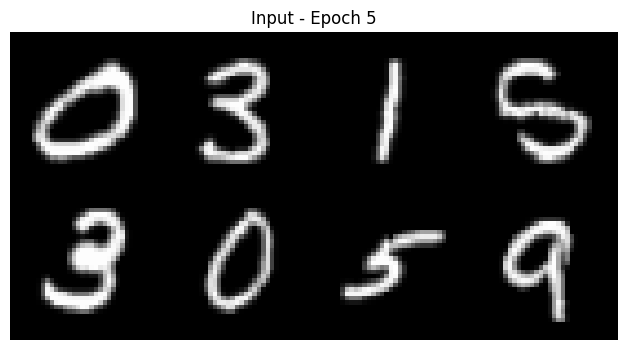

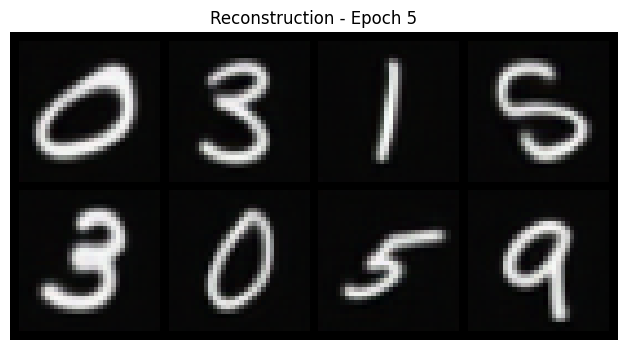

In [23]:
# Hiển thị ảnh đầu vào và tái tạo
show_tensor_images(images[:8], title=f"Input - Epoch {epoch+1}")
show_tensor_images(recon_images[:8], title=f"Reconstruction - Epoch {epoch+1}")


#Train SD

In [24]:
def train_diffusion_one_epoch(dataloader, encoder, diffusion_model, clip_model, tokenizer, optimizer, sampler, device):
    encoder.eval()             # Freeze VAE encoder
    diffusion_model.train()    # Chỉ train diffusion
    clip_model.eval()          # Freeze CLIP

    total_loss = 0
    image_size = 32  # Resize MNIST thành 32x32

    for images, labels in tqdm(dataloader, desc="Training"):
        images = images.to(device)
        labels = labels.to(device)

        # Chuyển MNIST từ 1 kênh sang 3 kênh
        images = images.repeat(1, 3, 1, 1)  # (B, 1, H, W) -> (B, 3, H, W)

        # ----- Encode ảnh thành latent -----
        with torch.no_grad():
            noise = torch.randn(images.size(0), 4, image_size // 16, image_size // 16, device=device)
            latents = encoder(images, noise=noise)  # (B, 4, H/8, W/8)

        # ----- Text Prompt → Tokenize → CLIP -----
        prompts = [f"Write number {label.item()}" for label in labels]
        inputs = tokenizer(prompts, padding="max_length", truncation=True, max_length=77, return_tensors="pt").to(device)

        with torch.no_grad():
            context = clip_model.text_model(**inputs).last_hidden_state  # (B, 77, 512)

        # ----- Sample timestep t -----
        B = latents.size(0)
        timesteps = torch.randint(0, sampler.num_steps, (B,), device=device)

        # ----- Add noise x_t = sqrt(a)*x_0 + sqrt(1-a)*eps -----
        x_t = sampler.add_noise(latents, timesteps)

        # ----- Get time embedding -----
        time_embed = torch.cat([get_time_embedding(t.item()) for t in timesteps], dim=0).to(device)  # (B, 320)

        # ----- Predict noise -----
        pred_noise = diffusion_model(x_t, context, time_embed)

        # ----- Loss -----
        true_noise = x_t - latents
        loss = F.mse_loss(pred_noise, true_noise)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(dataloader)
    return avg_loss


In [25]:
encoder.eval()
decoder.eval()

diffusion_model = Diffusion().to(device)


generator = torch.Generator(device=device).manual_seed(42)
sampler = DDPMSampler(generator)

optimizer = torch.optim.Adam(diffusion_model.parameters(), lr=1e-4)


In [26]:
from transformers import CLIPTokenizer, CLIPTextModel

tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-base-patch32")
clip_text_model = CLIPTextModel.from_pretrained("openai/clip-vit-base-patch32").to(device)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/862k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.22M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.19k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

In [27]:
for epoch in range(epochs):
    loss = train_diffusion_one_epoch(
        dataloader=dataloader,
        encoder=encoder,
        diffusion_model=diffusion_model,
        clip_model=clip_text_model,
        tokenizer=tokenizer,
        optimizer=optimizer,
        sampler=sampler,
        device=device
    )
    print(f"Epoch {epoch+1}: Loss = {loss:.4f}")


Training:   0%|          | 1/938 [00:00<10:27,  1.49it/s]

model.safetensors:   0%|          | 0.00/605M [00:00<?, ?B/s]

Training: 100%|██████████| 938/938 [04:33<00:00,  3.43it/s]


Epoch 1: Loss = 0.1835


Training: 100%|██████████| 938/938 [04:31<00:00,  3.46it/s]


Epoch 2: Loss = 0.1596


Training: 100%|██████████| 938/938 [04:31<00:00,  3.46it/s]


Epoch 3: Loss = 0.1573


Training: 100%|██████████| 938/938 [04:31<00:00,  3.46it/s]


Epoch 4: Loss = 0.1554


Training: 100%|██████████| 938/938 [04:31<00:00,  3.46it/s]

Epoch 5: Loss = 0.1547


#Inference

In [58]:
# Cấu hình
batch_size = 1
latent_shape = (batch_size, 4, 2, 2)
generator = torch.Generator(device=device).manual_seed(42)

# Noise ban đầu
x_t = torch.randn(latent_shape, device=device, generator=generator)


In [59]:
prompt = ["Write number 5"]
inputs = tokenizer(prompt, padding="max_length", truncation=True, max_length=77, return_tensors="pt").to(device)

with torch.no_grad():
    context = clip_text_model.text_model(**inputs).last_hidden_state  # (1, 77, 768)


In [60]:
sampler.set_inference_timesteps(50)
timesteps = sampler.timesteps

for t in tqdm(timesteps):
    # Time embedding
    time_embed = get_time_embedding(t.item()).to(device)

    # Predict noise
    with torch.no_grad():
        pred_noise = diffusion_model(x_t, context, time_embed)

    # Update latent
    x_t = sampler.step(t, x_t, pred_noise)


100%|██████████| 50/50 [00:00<00:00, 75.56it/s]


In [61]:
with torch.no_grad():
    img_out = decoder(x_t)  # (1, 3, 32, 32)

# Chuyển về ảnh hiển thị
img_out = img_out[0].detach().cpu()
img_out = (img_out + 1) / 2


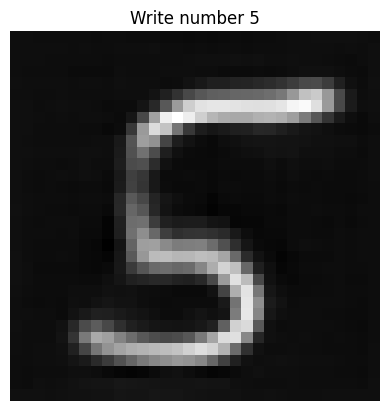

In [62]:
import torchvision.transforms.functional as TF

gray_img = TF.rgb_to_grayscale(img_out)

# Hiển thị
import matplotlib.pyplot as plt

plt.imshow(gray_img.squeeze(0), cmap='gray')
plt.axis('off')
plt.title(prompt[0])
plt.show()
